In [8]:
import tensorflow as tf
from qiskit import *
from qiskit.providers.ibmq import *
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential#,Input,Model
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# from tensorflow import keras
# from keras_layer_normalization import BatchNormalization
# from keras_layer_normalization import LayerNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
def clear_dataset(df, n_qubits):
    df = df.drop_duplicates()
    for i in range(n_qubits):
        df = df.drop('measure_' + str(i), axis=1)
    #Rimozione Features non interessanti
    df = df.drop('N_measure', axis = 1)
    # remove edges which are not in coupling maps
    # connections = ['01','10','12','21','13','31','35','53','45','54','56','65']
    connections = []
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    provider.backends(simulator=False)
    if n_qubits == 7:
        backend = provider.get_backend('ibm_nairobi')
        coupling_map = IBMQBackend.configuration(backend).to_dict()['coupling_map']
        for tup in coupling_map:
            connections.append(str(tup[0])+str(tup[1]))
    else:
        backend = provider.get_backend('ibm_brisbane')
        coupling_map = IBMQBackend.configuration(backend).to_dict()['coupling_map']
        for tup in coupling_map:
            connections.append(str(tup[0])+str(tup[1]))
    print("Connections:",connections)
    to_keep = []
    for c in connections:
        to_keep.append("edge_error_"+c)    
        to_keep.append("edge_length_"+c)
    to_drop = []
    for c in df.columns:
        if "edge_error" in c or "edge_length" in c:
            if c not in to_keep:
                to_drop.append(c)
    df = df.drop(to_drop,axis=1)
    return df

In [3]:
num_qubits = 7
df = pd.read_csv("NN1_Dataset(\uf03c=10Cx)_balanced1.csv")
df = clear_dataset(df, num_qubits)
df

Connections: ['01', '10', '12', '13', '21', '31', '35', '45', '53', '54', '56', '65']


,Unnamed: 0,last_update_date,backend_name,N_qubtis,N_cx,cx_01,cx_02,cx_03,cx_04,cx_05,...,T1_6,T2_6,readout_error_6,0,1,2,3,4,5,6
0,0,2023-07-06 13:10:36-07:00,ibm_lagos,7,53,6,0,0,0,0,...,44.734718,92.600073,0.0137,2,1,0,3,4,5,6
1,1,2023-07-06 13:10:36-07:00,ibm_lagos,7,40,2,0,0,0,0,...,44.734718,92.600073,0.0137,2,1,0,3,4,5,6
2,2,2023-07-06 13:10:36-07:00,ibm_lagos,7,23,2,0,0,0,0,...,44.734718,92.600073,0.0137,0,1,2,3,4,5,6
3,3,2023-07-06 13:10:36-07:00,ibm_lagos,7,37,3,0,0,0,0,...,44.734718,92.600073,0.0137,2,1,0,3,6,5,4
4,4,2023-07-06 14:11:03-07:00,ibm_perth,7,73,4,0,0,0,0,...,234.956902,240.488458,0.0090,0,1,2,3,4,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,8892,2023-07-19 14:53:52-07:00,ibm_perth,7,18,7,0,0,0,0,...,254.488154,313.822759,0.0087,0,1,2,3,4,5,6
8893,8893,2023-07-19 14:42:36-07:00,ibm_nairobi,7,48,4,0,0,0,0,...,109.585360,141.228784,0.0256,2,1,0,3,6,5,4
8894,8894,2023-06-07 15:11:48-07:00,ibm_lagos,7,86,7,0,0,0,0,...,161.383544,104.767721,0.0144,2,1,0,3,4,5,6
8895,8895,2023-06-07 14:34:17-07:00,ibm_perth,7,33,2,0,0,0,0,...,175.573329,244.762409,0.0073,0,1,2,3,4,5,6


In [4]:
last_num_qubits = len(df.columns)-num_qubits
labels = df.iloc[:, last_num_qubits:].values
"""
Node fatures: T1, T2,readout_error (N*3)
Edge features: CNOTs, edge_error, edge_length ((edges*3))
edge_features -> ((t1_i,t2_i,readout_i),(t1_j,t2_j,readout_j),(edge_error_ij,edge_length_ij,cnot_ij))

"""
X,X_ev = [],[]
for i in tqdm(range(len(df))):
    edge_features = []
    for edge_i in range(num_qubits):
        for edge_j in range(num_qubits):
            if edge_i != edge_j:
                cx = df["cx_"+str(edge_i)+str(edge_j)][i]
                edge_error, edge_length  = 100000, 100000
                if "edge_error_"+str(edge_i)+str(edge_j) in df.columns:
                    edge_error = df["edge_error_"+str(edge_i)+str(edge_j)][i]
                    edge_length = df["edge_length_"+str(edge_i)+str(edge_j)][i]
                
                t1_i = df["T1_"+str(edge_i)][i]
                t2_i = df["T2_"+str(edge_i)][i]
                readout_i = df["readout_error_"+str(edge_i)][i]
            
                t1_j = df["T1_"+str(edge_j)][i]
                t2_j = df["T2_"+str(edge_j)][i]
                readout_j = df["readout_error_"+str(edge_j)][i]
                
#                 if cx != 0:
                    
                
                edge_features.append(np.array([t1_i,t2_i,readout_i,t1_j,t2_j,readout_j,cx,edge_error,edge_length]))
    X.append(np.array(edge_features).flatten())
X = np.array(X)

100%|█████████████████████████████████████████████████████████████████████████████| 8897/8897 [00:19<00:00, 449.49it/s]


In [5]:
X.shape, X[0].shape

((8897, 378), (378,))

In [6]:
y_old =(df.iloc[:, last_num_qubits:].values)
y = []
for i in range(len(y_old)):
    n = len(y_old[i])
    y_new = np.array(([[0]*n]*n))
    for j in range(len(y_old[i])):
        y_new[j][y_old[i][j]] = 1
    y_new = y_new.flatten()
    y.append(y_new)
    
y=np.array(y)
y.shape



(8897, 49)

In [9]:
SS = StandardScaler()
X_st = SS.fit_transform(X)
#MS = MinMaxScaler()
#X_st = MS.fit_transform(X)

#Building validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.10, random_state=1)

In [10]:
def build_model(input_shape):
        #d = 0.2
        model = Sequential()
        input_layer = Input(shape=input_shape, name='input')
        layer1 = Dense(input_shape//2,kernel_initializer='uniform',activation='relu')(input_layer)
        layer2 = Dense(input_shape//4,kernel_initializer='uniform',activation='relu')(layer1)
        layer3 = Dense(49,kernel_initializer='uniform',activation='relu')(layer2)
        merged = Model(inputs=[input_layer], outputs=[layer3])

        return merged
    
    
    
def build_model_y_7(input_shape):
        #d = 0.2
        model = Sequential()
        input_layer = Input(shape=input_shape, name='input')
        layer1 = Dense(input_shape//2,kernel_initializer='uniform',activation='relu')(input_layer)
        layer2 = Dense(input_shape//4,kernel_initializer='uniform',activation='relu')(layer1)
        layer3 = Dense(input_shape//8,kernel_initializer='uniform',activation='relu')(layer2)
        layer4 = Dense(input_shape//16,kernel_initializer='uniform',activation='relu')(layer3)
        layer5 = Dense(7,kernel_initializer='uniform',activation='relu')(layer4)
        merged = Model(inputs=[input_layer], outputs=[layer5])

        return merged

model = build_model(X[0].shape[0])
# model = build_model_y_7(X[0].shape[0])
model.build(X[0].shape[0])
# model.compile(loss='mean_squared_error',optimizer='adam')
learning_rate = 0.01
optimizer = tf.optimizers.Adam(name='Adam', learning_rate=learning_rate)
model.compile(
  optimizer=optimizer,
  loss='mean_squared_error',
  metrics=[tf.keras.metrics.mean_squared_error])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 378)]             0         
                                                                 
 dense (Dense)               (None, 189)               71631     
                                                                 
 dense_1 (Dense)             (None, 94)                17860     
                                                                 
 dense_2 (Dense)             (None, 49)                4655      
                                                                 
Total params: 94146 (367.76 KB)
Trainable params: 94146 (367.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
X[0].shape[0]//32

11

In [12]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=125,
    validation_split=0.15,
    verbose=1)

print(history.history.keys())

Epoch 1/125
14/14 [==============================] - 1s 16ms/step - loss: 0.0786 - mean_squared_error: 0.0786 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 2/125
14/14 [==============================] - 0s 8ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 3/125
14/14 [==============================] - 0s 7ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0338 - val_mean_squared_error: 0.0338
Epoch 4/125
14/14 [==============================] - 0s 8ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 5/125
14/14 [==============================] - 0s 7ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 6/125
14/14 [==============================] - 0s 7ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 7/125
14/14 [==============

14/14 [==============================] - 0s 6ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0192 - val_mean_squared_error: 0.0192
Epoch 52/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 53/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 54/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 55/125
14/14 [==============================] - 0s 7ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 56/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 57/125
14/14 [=====================

14/14 [==============================] - 0s 6ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 102/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 103/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 104/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 105/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 106/125
14/14 [==============================] - 0s 6ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 107/125
14/14 [===============

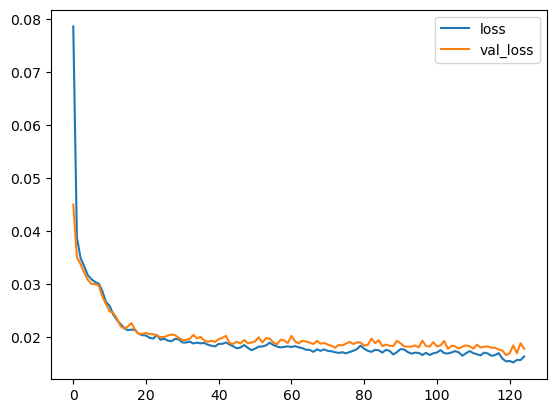

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'] , label = "loss")
plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")
plt.legend()
plt.show()

In [14]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

251/251 [==============================] - 0s 850us/step


In [15]:
def get_labels(y):
    labels = []
    for i in range(len(y)):
        labels.append(np.where(y[i]==np.max(y[i]))[0][0])
#         for j in range(len(y[i])):
#             if y[i][j] != 0:
#                 labels.append(j)
                
    return labels

count = 0
for i in range(len(train_pred)):
    actual=get_labels(np.reshape(y_train[i],(7,7)))
    predicted=get_labels(np.reshape(train_pred[i],(7,7)))
#     print(actual)
#     print(predicted)
#     print("---------------------------")
    if actual == predicted:
        count = count + 1
        
print("Test accuracy:",count/len(train_pred))

Test accuracy: 0.8313975271637317


In [16]:
count = 0
for i in range(len(test_pred)):
    actual=get_labels(np.reshape(y_test[i],(7,7)))
    predicted=get_labels(np.reshape(test_pred[i],(7,7)))
#     print(actual)
#     print(predicted)
#     print("---------------------------")
    if actual == predicted:
        count = count + 1
        
print("Test accuracy:",count/len(test_pred))

Test accuracy: 0.8123595505617978
